In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Circle
import unyt
import swiftsimio as sw
from swiftgalaxy import SWIFTGalaxy, SOAP
from swiftsimio.visualisation.projection import project_gas, project_pixel_grid
from swiftsimio.visualisation import generate_smoothing_lengths
from scipy.spatial.transform import Rotation

In [ ]:
# Good galaxy imaging options (in the L25m5 run)
# ID 479 at z=0 (snap 123)
#       Very nice spiral-looking thing
#
# ID 16240 at z=0.5 (snap 98)
#       Sensible spiral, maybe some issues with the rotation
#
# ID 160708 at z=1 (snap 88)
#       Problem galaxy, doesn't rotate to face-on well

In [3]:
colibre_base_path = "/mnt/su3-pro/colibre/"
simulation_dir = "L0025N0752/THERMAL_AGN"

soap_path_z05 = "SOAP/halo_properties_0098.hdf5"
soap_catalogue_file_z05 = os.path.join(colibre_base_path, simulation_dir, soap_path_z05)
virtual_snapshot_path_z05 = "SOAP/colibre_with_SOAP_membership_0098.hdf5"
virtual_snapshot_file_z05 = os.path.join(colibre_base_path, simulation_dir, virtual_snapshot_path_z05)

ID_z05 = 16240


sg05 = SWIFTGalaxy(
    virtual_snapshot_file_z05,
    SOAP(
        soap_catalogue_file_z05,
        soap_index=ID_z05
    ),
)

Lstars = sg05.halo_catalogue.exclusive_sphere_30kpc.angular_momentum_stars.squeeze() #10kpc, 30kpc?
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    unyt.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat)).T
sg05.rotate(Rotation.from_matrix(rotmat)) # hopefully this puts the galaxy face-on

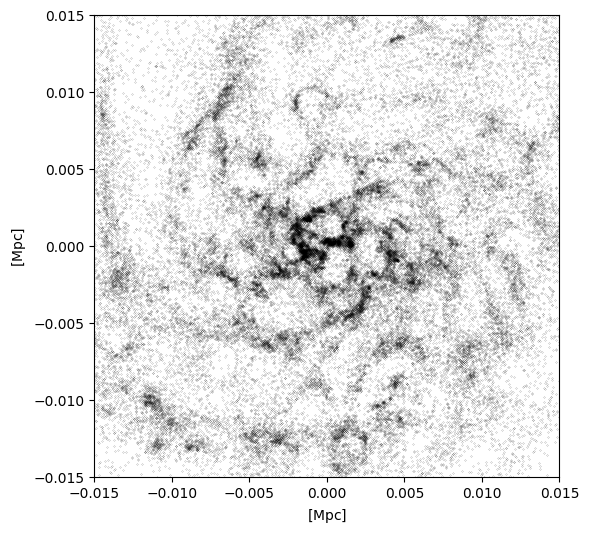

In [4]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0], sg05.gas.coordinates[:,1],c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

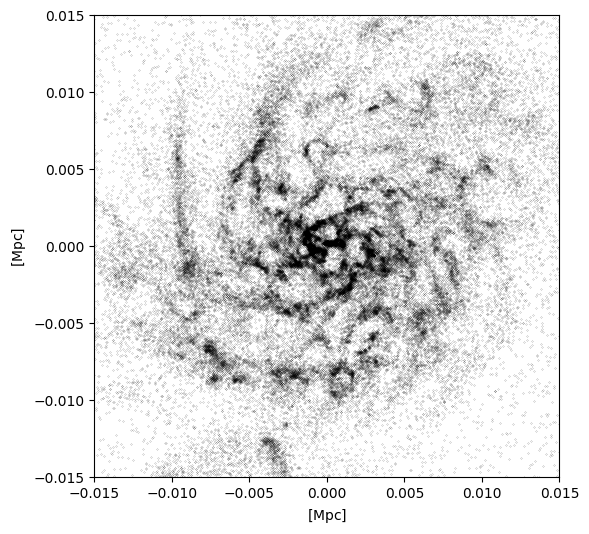

In [5]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0].to_physical(), sg05.gas.coordinates[:,1].to_physical(),c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

In [6]:
disc_radius = 15.0*unyt.kpc
disc_radius_c = 15.0*unyt.kpc / sg05.metadata.a

disc_region = sw.objects.cosmo_array(
        [-1*disc_radius, disc_radius, -1*disc_radius, disc_radius],
        comoving=False,
        scale_factor=sg05.metadata.a,
        scale_exponent=1,
)

disc_region_c = sw.objects.cosmo_array(
        [-1*disc_radius_c, disc_radius_c, -1*disc_radius_c, disc_radius_c],
        comoving=True,
        scale_factor=sg05.metadata.a,
        scale_exponent=1,
)

In [7]:
print(disc_region)
print(disc_region_c)

[-15.  15. -15.  15.] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


In [8]:
gas_map = project_gas(
        sg05,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

gas_map_c = project_gas(
        sg05,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region_c,
)

In [9]:
print(disc_region)
print(disc_region_c)

[-22.5  22.5 -22.5  22.5] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


In [10]:
star_map = project_pixel_grid(
        data=sg05.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

star_map_c = project_pixel_grid(
        data=sg05.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region_c,
)

In [11]:
print(disc_region)
print(disc_region_c)

[-33.75  33.75 -33.75  33.75] kpc (Physical)
[-22.5  22.5 -22.5  22.5] kpc (Comoving)


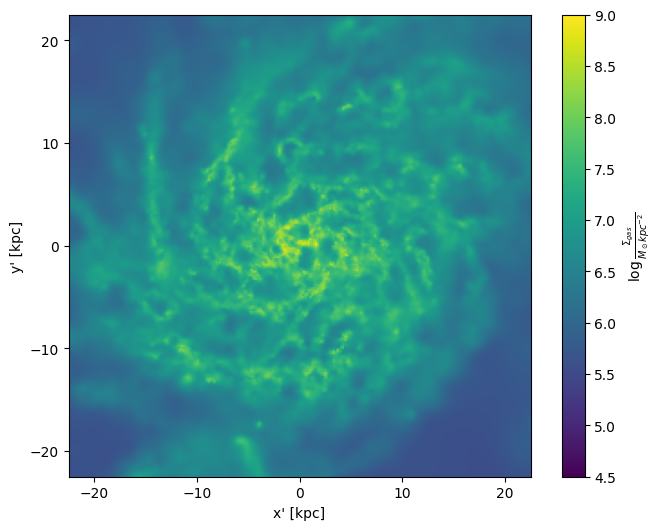

In [12]:
gmin = 4.5
gmax = 9

fig,ax = plt.subplots(1,1,figsize=(8,6))
mp = ax.imshow(
    np.log10(gas_map_c.to_value(unyt.solMass / unyt.kpc**2).T),
    cmap="viridis",
    extent=disc_region_c,
    origin="lower",
    vmin=gmin,
    vmax=gmax,
)
ax.set_xlabel(f"x' [{disc_radius.units}]")
ax.set_ylabel(f"y' [{disc_radius.units}]")
cb = fig.colorbar(mp, ax=ax,label=r'$\log \frac{\Sigma_{gas}}{M_\odot kpc^{-2}}$')

In [13]:
colibre_base_path = "/mnt/su3-pro/colibre/"
simulation_dir = "L0025N0752/THERMAL_AGN"

soap_path_z05 = "SOAP/halo_properties_0098.hdf5"
soap_catalogue_file_z05 = os.path.join(colibre_base_path, simulation_dir, soap_path_z05)
virtual_snapshot_path_z05 = "SOAP/colibre_with_SOAP_membership_0098.hdf5"
virtual_snapshot_file_z05 = os.path.join(colibre_base_path, simulation_dir, virtual_snapshot_path_z05)

ID_z05 = 16240


sg05 = SWIFTGalaxy(
    virtual_snapshot_file_z05,
    SOAP(
        soap_catalogue_file_z05,
        soap_index=ID_z05
    ),
)

Lstars = sg05.halo_catalogue.exclusive_sphere_30kpc.angular_momentum_stars.squeeze() #10kpc, 30kpc?
zhat = (Lstars / np.sqrt(np.sum(Lstars**2))).to_value(
    unyt.dimensionless
)  # we'll align L with the z-axis
arb = np.ones(3) / np.sqrt(
    3
)  # we have one degree of freedom, we'll fix it by projecting onto an arbitrarily chosen vector
xvec = arb - arb.dot(zhat) * zhat
xhat = xvec / np.sum(xvec**2)
yhat = np.cross(zhat, xhat)  # orthogonal, right-handed and normalized
rotmat = np.vstack((xhat, yhat, zhat)).T
sg05.rotate(Rotation.from_matrix(rotmat)) # hopefully this puts the galaxy face-on

In [14]:
sg05.gas.masses

cosmo_array([2.0629854e-05, 2.1907765e-05, 2.5129553e-05, ..., 2.1000840e-05,
       2.6857322e-05, 2.5324802e-05], shape=(184102,), dtype=float32, units='10000000000.0*Msun', comoving='True', cosmo_factor='1 at a=0.6666666666666665', valid_transform='True')

In [15]:
sg05.gas.coordinates

cosmo_array([[-0.51776827,  0.01059908,  0.73587626],
       [-0.50303484,  0.0245475 ,  0.76225227],
       [-0.56490069,  0.1165456 ,  0.79302052],
       ...,
       [ 0.27636724,  0.01436736,  0.05519856],
       [ 0.25954102,  0.02016611,  0.07785863],
       [ 0.59317967, -0.21106083, -0.18592154]], shape=(184102, 3), units='Mpc', comoving='True', cosmo_factor='a**1.0 at a=0.6666666666666665', valid_transform='True')

In [29]:
sg05.gas.masses.convert_to_physical()
sg05.gas.coordinates.convert_to_physical()
sg05.gas.smoothing_lengths.convert_to_physical()

sg05.stars.masses.convert_to_physical()
sg05.stars.coordinates.convert_to_physical()
sg05.stars.smoothing_lengths.convert_to_physical()

In [17]:
sg05.gas.masses

cosmo_array([2.0629854e-05, 2.1907765e-05, 2.5129553e-05, ..., 2.1000840e-05,
       2.6857322e-05, 2.5324802e-05], shape=(184102,), dtype=float32, units='10000000000.0*Msun', comoving='False', cosmo_factor='1 at a=0.6666666666666665', valid_transform='True')

In [20]:
sg05.gas.coordinates

cosmo_array([[-0.34517885,  0.00706606,  0.49058418],
       [-0.33535656,  0.016365  ,  0.50816818],
       [-0.37660046,  0.07769707,  0.52868034],
       ...,
       [ 0.18424483,  0.00957824,  0.03679904],
       [ 0.17302734,  0.01344407,  0.05190575],
       [ 0.39545311, -0.14070722, -0.1239477 ]], shape=(184102, 3), units='Mpc', comoving='False', cosmo_factor='a**1.0 at a=0.6666666666666665', valid_transform='True')

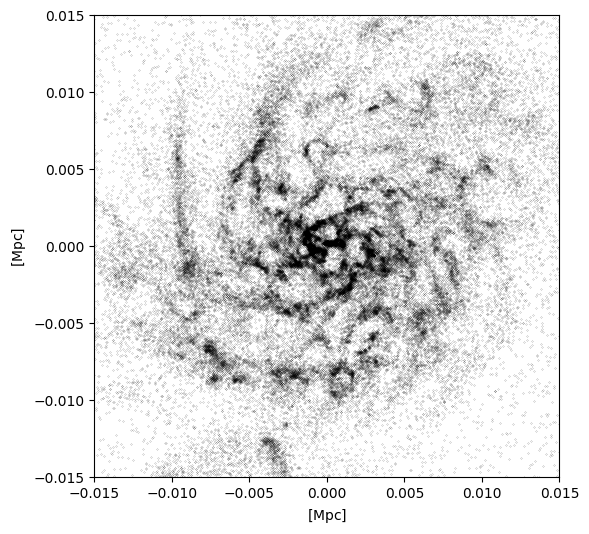

In [22]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0], sg05.gas.coordinates[:,1],c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

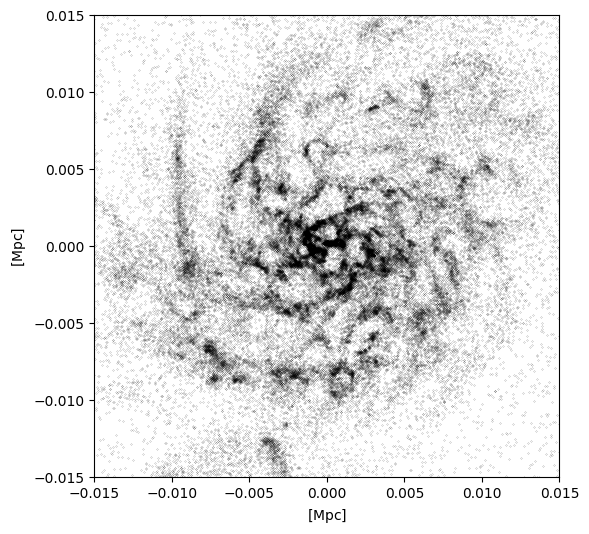

In [23]:
unyt.matplotlib_support.label_style = '[]'
with unyt.matplotlib_support:
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    ax.scatter(sg05.gas.coordinates[:,0].to_physical(), sg05.gas.coordinates[:,1].to_physical(),c='k',s=0.01)
    ax.set_xlim([-0.015,0.015])
    ax.set_ylim([-0.015,0.015])

    plt.show()

In [24]:
disc_radius = 15.0*unyt.kpc
disc_radius_c = 15.0*unyt.kpc / sg05.metadata.a

disc_region = sw.objects.cosmo_array(
        [-1*disc_radius, disc_radius, -1*disc_radius, disc_radius],
        comoving=False,
        scale_factor=sg05.metadata.a,
        scale_exponent=1,
)

In [27]:
print(disc_region)

[-15.  15. -15.  15.] kpc (Physical)


In [30]:
gas_map = project_gas(
        sg05,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

star_map = project_pixel_grid(
        data=sg05.stars,
        resolution=256,
        project="masses",
        parallel=True,
        periodic=False,
        region=disc_region,
)

In [38]:
R50 = sg05.halo_catalogue.exclusive_sphere_30kpc.half_mass_radius_stars.squeeze()
R50.convert_to_physical()


In [39]:
R50

cosmo_array(0.00363159, dtype=float32, units='Mpc', comoving='False', cosmo_factor='a at a=0.6666666666666665', valid_transform='True')

In [49]:
circle = plt.Circle((0,0), R50/unyt.kpc, color='k',fill=False)

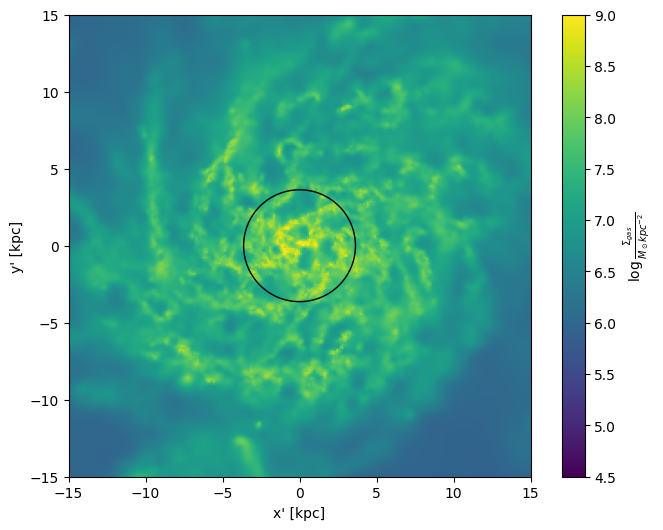

In [50]:
gmin = 4.5
gmax = 9

fig,ax = plt.subplots(1,1,figsize=(8,6))
mp = ax.imshow(
    np.log10(gas_map.to_value(unyt.solMass / unyt.kpc**2).T),
    cmap="viridis",
    extent=disc_region,
    origin="lower",
    vmin=gmin,
    vmax=gmax,
)
ax.add_patch(circle)
ax.set_xlabel(f"x' [{disc_radius.units}]")
ax.set_ylabel(f"y' [{disc_radius.units}]")
cb = fig.colorbar(mp, ax=ax,label=r'$\log \frac{\Sigma_{gas}}{M_\odot kpc^{-2}}$')